<a target="_blank" href="https://colab.research.google.com/github/trainocate-japan/Machine-Learning-and-Deep-Learning-Hands-on/blob/main/answer/7_CNNによる画像分類/7-4_（演習）PyTorchによる服の画像分類.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 7-4_（演習）PyTorchによる服の画像分類
このノートブックではPyTorchを用いて画像分類を行うモデルを作成します。<br>
テーマはFashion-MNISTという服の種別を判別するものです。

MNISTと画像のサイズやデータ量などが同じなので、MNISTで試した手法を同じように用いることができますが、判別するものが手書き文字から服に代わっているため、分類の難易度が上がっています。

## ランタイムをGPUに切り替える
画像分類では非常に多くのコンピューティングリソースを使うため、CPUではとても時間がかかってしまいます。
そこで、Google ColaboratoryのランタイムをGPUに切り替えます。

ランタイムをGPUに切り替えるには、上部のメニューから「ランタイム > ランタイムのタイプを変更」を選択し、ハードウェアアクセラレーターでGPUを選択して、保存をクリックします。

PyTorchでは、別途GPUを使うためのプログラミングが必要ですが、Kerasの場合は自動的にランタイムを判断して、GPUが使用できる場合にはGPUを使用して演算を行います。

## ライブラリのインポート

In [1]:
# データを処理するための基本的なライブラリ
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# データセット用
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# PyTorchで使用
import torch

#### GPUチェック

In [2]:
# デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## データの準備

#### Transformsによるデータの前処理
pytorchにはデータ変換を定義することで、datasetにする際に自動でデータ変換を行ってくれるTransforms機能があります。

torchvisionに含まれるデータセットを使用する場合には、ダウンロードと共にTransformsで変換しつつdatasetにすることができるので大変便利です。

今回はtorchvisionからデータをダウンロードするので、この機能を利用してデータをtorchtensorに変換します。

また、Transformsを使用してデータのスケールを変更することもできます。今回はすでにデータが0～1の範囲で正規化されているため、この作業は行いません。

In [3]:
# データ変換用関数 Transforms
transform = transforms.Compose([
    # データのテンソル化
    transforms.ToTensor(),
])

trochvisionのデータセットを使ってFashion-MNISTのデータをダウンロードします。

Fasion-MNISTは服の種類を0から9までのカテゴリクラスでラベル付けしている画像データ7万件です。それぞれのクラスとラベルの紐づけは以下のようになっています。

|Label|	Description|
|----|----|
|0|	T-shirt/top|
|1|	Trouser|
|2|	Pullover|
|3|	Dress|
|4|	Coat|
|5|	Sandal|
|6|	Shirt|
|7|	Sneaker|
|8|	Bag|
|9|	Ankle boot|

訓練データ6万件と検証データ1万件に最初から分けてあるので、それぞれ変数に格納します。

In [4]:
# データ取得用関数 Dataset

# 訓練用データセットの定義
train_set = datasets.FashionMNIST(
    root = './data', # ダウンロード先ディレクトリ名 
    train = True,
    download = True,
    transform = transform)

# 検証データセットの定義
val_set = datasets.FashionMNIST(
    root = './data', 
    train = False, 
    download = True, 
    transform = transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



## モデルの定義
fasion-MNISTではMNISTより層数を増やすなどの工夫が必要です。

In [5]:
# 乱数の固定化
torch.manual_seed(123)
torch.cuda.manual_seed(123) # GPUのための乱数固定

# モデルの定義

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 畳み込み層
        # 引数は順番に「入力チャネル数」「出力チャネル数」「畳み込みカーネルの一辺のサイズ」
        # paddingオプションで入力画像の外側に縦横2ピクセルのパディングを行い、畳み込み後も画像サイズを維持する。
        self.conv = torch.nn.Conv2d(1, 32, 5, padding=(2,2))
        # 活性化関数ReLU
        self.relu = torch.nn.ReLU(inplace=True)
        self.dropout1 = torch.nn.Dropout(0.3)
        # プーリング層
        self.maxpool = torch.nn.MaxPool2d((2,2))
        # 畳み込み層
        self.conv = torch.nn.Conv2d(1, 64, 5, padding=(2,2))
        self.relu = torch.nn.ReLU(inplace=True)
        self.dropout1 = torch.nn.Dropout(0.3)
        self.conv = torch.nn.Conv2d(1, 32, 5, padding=(2,2))
        self.relu = torch.nn.ReLU(inplace=True)
        self.dropout1 = torch.nn.Dropout(0.3)
        # 全結合層
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(6272, 1024)
        # forward定義時にここにReLUを挟む
        self.dropout2 = torch.nn.Dropout(0.3)
        self.linear2 = torch.nn.Linear(1024, 10)
   
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.linear2(x)
        return x

# 後で設定するPyTorchのCrossEntropyLossは、softmax関数を内包するような損失関数になっています。
# そのため、Softmax関数を最後に入れる必要がありません。
# ただし、確率値を求めたい場合には予測値にsoftmax関数を用いる必要があります。

## 学習

In [6]:
num_epochs = 10

# データローダーの用意
batch_size = 256
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = False)

# モデルをインスタンス化
net = Net()
net = net.to(device) # ★モデルをGPU側に送る。GPUを使用する場合に必要
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

## 学習に必要な空リストを作成
train_loss_list = []#学習損失
train_accuracy_list = []#学習データ正解率
val_loss_list = []#評価損失
val_accuracy_list = []#検証データの正答率

for epoch in range(num_epochs):
    
    #学習の進行状況を表示
    print('--------')
    print("Epoch: {}/{}".format(epoch + 1, num_epochs))

    #損失と正解率の初期化
    train_loss = 0      #学習損失
    train_accuracy = 0  #学習データの正答数
    val_loss = 0        #評価損失
    val_accuracy = 0    #検証データの正答数

    #学習モードに設定
    net.train()

    #ミニバッチごとにデータをロードして学習
    for x, y in train_dataloader:
        
        # GPUヘ転送
        x = x.to(device)
        y = y.to(device)

        preds = net(x)
        predlabels = torch.max(preds, 1)[1] # 予測ラベル導出
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #ミニバッチごとの損失と精度を備蓄
        train_loss += loss.item()
        train_accuracy += (y == predlabels).sum() / batch_size
    
    #ミニバッチの平均の損失と正解率を計算
    batch_train_loss = train_loss / len(train_dataloader)
    batch_train_accuracy = train_accuracy / len(train_dataloader)

    #評価モードに設定
    net.eval()
    #評価時に自動微分をゼロにする
    with torch.no_grad():
        for x, y in val_dataloader:

            # GPUヘ転送
            x = x.to(device)
            y = y.to(device)

            #データを入力して予測値を計算
            preds = net(x)
            predlabels = torch.max(preds, 1)[1] # 予測ラベル導出
            #損失を計算
            loss = criterion(preds, y)
            #ミニバッチごとの損失と精度を備蓄
            val_loss += loss.item()
            val_accuracy += (y == predlabels).sum() / batch_size

    #ミニバッチの平均の損失と正解率を計算
    batch_val_loss = val_loss / len(val_dataloader)
    batch_val_accuracy = val_accuracy / len(val_dataloader)
    #エポックごとに損失と正解率を表示
    print("Train_Loss: {:.4f} Train_Accuracy: {:.4f}".format(batch_train_loss, batch_train_accuracy))
    print("val_loss: {:.4f} val_accuracy: {:.4f}".format(batch_val_loss, batch_val_accuracy))
    #損失と正解率をリスト化して保存
    train_loss_list.append(batch_train_loss)
    train_accuracy_list.append(batch_train_accuracy.cpu())
    val_loss_list.append(batch_val_loss)
    val_accuracy_list.append(batch_val_accuracy.cpu())

    # UserWarningが出力されることがありますが、Tensorに変換する際に名前付きテンソルというプロトタイプのテンソルが使われているためです。
    # 将来的に変更が加わる可能性を示唆されるものの、問題はありません。

--------
Epoch: 1/10
Train_Loss: 0.4686 Train_Accuracy: 0.8296
val_loss: 0.3588 val_accuracy: 0.8533
--------
Epoch: 2/10
Train_Loss: 0.3018 Train_Accuracy: 0.8888
val_loss: 0.3083 val_accuracy: 0.8712
--------
Epoch: 3/10
Train_Loss: 0.2633 Train_Accuracy: 0.9005
val_loss: 0.2913 val_accuracy: 0.8772
--------
Epoch: 4/10
Train_Loss: 0.2347 Train_Accuracy: 0.9096
val_loss: 0.2614 val_accuracy: 0.8831
--------
Epoch: 5/10
Train_Loss: 0.2135 Train_Accuracy: 0.9183
val_loss: 0.2571 val_accuracy: 0.8845
--------
Epoch: 6/10
Train_Loss: 0.1972 Train_Accuracy: 0.9240
val_loss: 0.2490 val_accuracy: 0.8895
--------
Epoch: 7/10
Train_Loss: 0.1796 Train_Accuracy: 0.9302
val_loss: 0.2404 val_accuracy: 0.8911
--------
Epoch: 8/10
Train_Loss: 0.1674 Train_Accuracy: 0.9348
val_loss: 0.2521 val_accuracy: 0.8875
--------
Epoch: 9/10
Train_Loss: 0.1503 Train_Accuracy: 0.9418
val_loss: 0.2312 val_accuracy: 0.8950
--------
Epoch: 10/10
Train_Loss: 0.1402 Train_Accuracy: 0.9450
val_loss: 0.2264 val_accura

## 評価

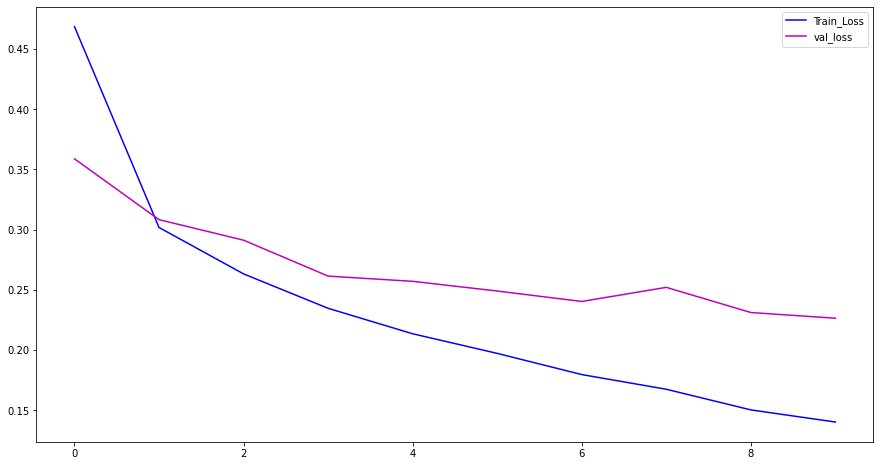

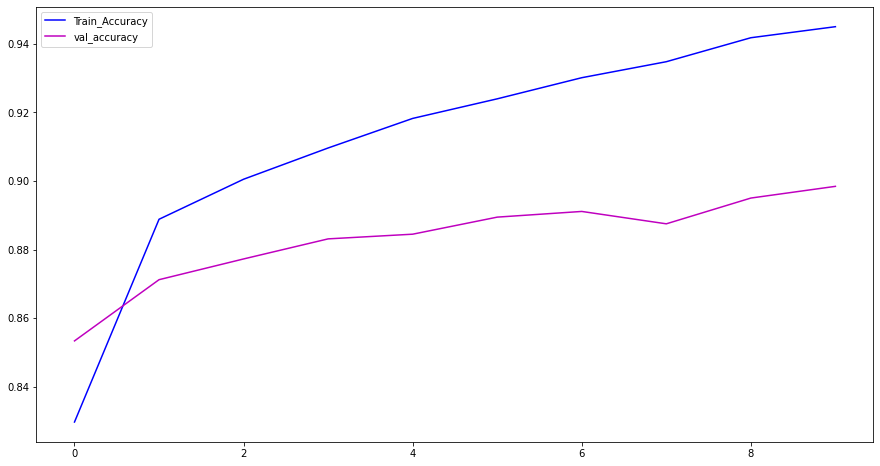

In [7]:
# 損失関数
plt.figure(figsize=(15, 8))
plt.plot(train_loss_list, color='b', label='Train_Loss')
plt.plot(val_loss_list, color='m', label='val_loss')
plt.legend()

# 精度
plt.figure(figsize=(15, 8))
plt.plot(train_accuracy_list, color='b', label='Train_Accuracy')
plt.plot(val_accuracy_list, color='m', label='val_accuracy')
plt.legend()

plt.show()

更に高い精度を出すためには、バッチ正規化・データ拡張などのさらなる工夫を試してみる必要があります。

(参考)予測をしてみる

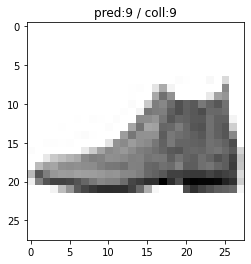

In [8]:
# 検証データn番目の画像で予測してみる
n = 0

# モデルを評価モードにする
net.eval()

y_pred = None
images = None
labels = None

# 検証用データローダからデータを一つのバッチだけ取り出す
with torch.no_grad():
  for x, y in val_dataloader:
    images = x
    labels = y
    break

# 予測を実行する
images = images.to(device)
pred = net(images)
pred =pred.to('cpu').detach().numpy().copy()
prediction = np.argmax(pred, axis=1)

# 画像をnumpyに直して表示できるようにしておく
images = images.to('cpu').detach().numpy().copy()

plt.title(f'pred:{prediction[n]} / coll:{labels[n]}')   # ラベルを設定
plt.imshow(images[n].reshape((28, 28)), vmin=0, vmax=1, cmap=plt.cm.gray_r) # 画像を表示
plt.show()